# Для запуска в Google Colab

Раскомментируйте команды ниже для запуска в Colab. Код был протестирован с Python 3.8 и PyTorch 1.8 CUDA 11.

**После установки зависимостей необходим перезапуск окружения** 

In [ ]:
# !apt install -y  git-lfs
# !git lfs version

In [ ]:
# %cd /content

In [ ]:
# !if [ ! -d ./made-adv-ml-hw2 ]; then git clone -b master --depth 1 --single-branch https://github.com/KernelA/made-adv-ml-hw2.git; fi

In [ ]:
# %cd /content/made-adv-ml-hw2

In [ ]:
# !git lfs pull

In [ ]:
# !pip install -r ./requirements.txt

In [ ]:
# !if [ -f ./.dvc/tmp/rwlock ]; then rm ./.dvc/tmp/rwlock; fi

In [ ]:
# !dvc repro train_test_split

In [9]:
import pathlib
import pickle
import shutil
import random

import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model
from scipy import sparse
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

plt.style.use("bmh")
mpl.rcParams["figure.figsize"] = (8, 8)

In [10]:
np.random.seed(12)
random.seed(22)
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)

In [11]:
%load_ext autoreload

%autoreload 2

In [12]:
from rating_model import TeamResults
from rating_model import PICKLE_PROTOCOL
from rating_model import EMRatingModel, get_player_skills, estimate_rank
from utils import load_pickle, dump_pickle, optimize_dataframe_numeric_dtypes

# 1 Предобработка данных

Основная логика предоработки данных содержится в .py файлах проекта.

In [13]:
tours_datapath = pathlib.Path("data", "pickle_data", "tournaments-dt.pickle")

In [14]:
tours = pd.read_pickle(tours_datapath)

In [15]:
players_datapath = pathlib.Path("data", "pickle_data", "players-dt.pickle")

In [16]:
players_info = pd.read_pickle(players_datapath)

In [17]:
team_res_datapath = pathlib.Path(
    "data", "team_res", "train_team_results.pickle")

In [18]:
team_res = load_pickle(team_res_datapath)

In [19]:
total_unknown_team_players = 0
total_unknown_answers = 0
for tour_id in team_res.tours:
    for team_id in team_res[tour_id]:
        team = team_res[tour_id][team_id]
        if not team.members:
            total_unknown_team_players += 1
        if not team.mask:
            total_unknown_answers += 1

In [20]:
print("Количество команд без состава команды: ", total_unknown_team_players,
      "Количество команд с неизвестными повопроснами результатами: ", total_unknown_answers, sep="\n")

Количество команд без состава команды: 
69
Количество команд с неизвестными повопроснами результатами: 
173


In [21]:
tours.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1727 entries, 3963 to 6485
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   name          1727 non-null   object             
 1   dateStart     1727 non-null   datetime64[ns, UTC]
 2   dateEnd       1727 non-null   datetime64[ns, UTC]
 3   type          1727 non-null   object             
 4   season        1637 non-null   object             
 5   orgcommittee  1727 non-null   object             
 6   synchData     1007 non-null   object             
 7   questionQty   1727 non-null   object             
dtypes: datetime64[ns, UTC](2), object(6)
memory usage: 121.4+ KB


In [22]:
players_dump = pathlib.Path("dump", "players.pickle")
players_dump.parent.mkdir(exist_ok=True, parents=True)

In [23]:
force_get_players = False

In [24]:
players = None

In [25]:
if not players_dump.exists() or force_get_players:
    players = team_res.to_player_dataframe(filter_by_mask=True)
    optimize_dataframe_numeric_dtypes(players)
    dump_pickle(players_dump, players)
else:
    players = load_pickle(players_dump)

In [26]:
assert players.index.is_monotonic_increasing

In [27]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17823516 entries, 0 to 17823515
Data columns (total 5 columns):
 #   Column           Dtype
---  ------           -----
 0   tour_id          int16
 1   team_id          int32
 2   player_id        int32
 3   answer_id        int32
 4   is_right_answer  bool 
dtypes: bool(1), int16(1), int32(3)
memory usage: 255.0 MB


In [28]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


## 2 Построение логистической регрессии для ранжирования игроков

Пусть параметры модели образуют составляют вектор $w = \left(s_1,s_2,\ldots,s_P, c_1, c_2, \ldots, c_A, b \right)^T,$ где $P-$ общее число игроков, $A-$ общее число вопросов. Таким образом значения параметров будут обозначать "силы игроков" $s_i, i=1,\ldots,P$ и сложнности вопросов $c_j, j=1,\ldots,A$, $b$- глоабальный коэффициент смещения/

Распредление ответов по всем игрокам:

<AxesSubplot:>

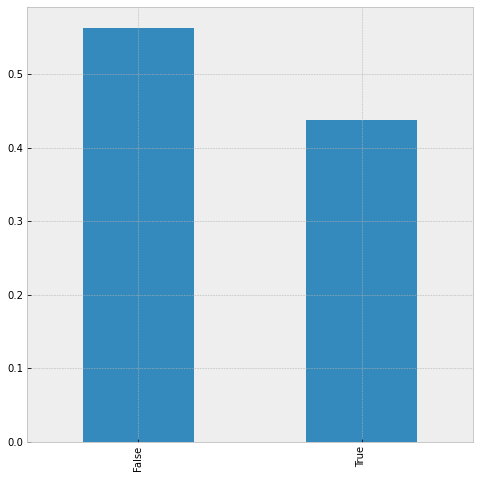

In [29]:
players["is_right_answer"].value_counts(normalize=True).plot.bar()

In [30]:
feature_dtype = np.float64

In [31]:
def get_features_target(players: pd.DataFrame, feature_dtype):
    skils_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)
    skils_features_one_hot = skils_encoder.fit_transform(players["player_id"].to_numpy().reshape(-1, 1))
    questione_complex_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)
    question_complices_one_hot = questione_complex_encoder.fit_transform(players["answer_id"].to_numpy().reshape(-1, 1))
    features = sparse.hstack(
    (skils_features_one_hot, question_complices_one_hot), format="csr")
    return skils_encoder, questione_complex_encoder, features, players["is_right_answer"].astype(np.int8).to_numpy()

In [32]:
skils_encoder, questione_complex_encoder, features, target = get_features_target(players, feature_dtype)

In [33]:
assert sparse.isspmatrix_csr(features)

In [34]:
features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in Compressed Sparse Row format>

In [35]:
dump_model_filepath = pathlib.Path("model", "log-reg")

In [36]:
dump_model_filepath.mkdir(parents=True, exist_ok=True)

In [37]:
force_train = False

In [38]:
model_dump = dump_model_filepath / "log-reg.pickle"

In [39]:
regression = None

In [40]:
if not force_train and model_dump.exists():
    regression = load_pickle(model_dump)

In [41]:
if regression is None:
    regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=25, fit_intercept=True)
    regression.fit(features, target)
    dump_pickle(model_dump, regression)

### Рейтинг игроков

Сравним позиции игроков на основе рейтингов с реальными позициями на момент [26 декабря 2019 (выгрузка содержит только первые 1000 записей)](https://rating.chgk.info/players.php?release=1429&surname=&name=&patronymic=&idplayer=28751&town=&search=%D0%98%D1%81%D0%BA%D0%B0%D1%82%D1%8C)

In [42]:
path_to_real_ratings = pathlib.Path(
    "data", "raw_data", "players-release-2019-12-26.csv")

In [43]:
top_n = 10

In [44]:
real_data = pd.read_csv(path_to_real_ratings, usecols=[
                        "id", "Место"], index_col="id", nrows=top_n)

In [45]:
player_ratings = get_player_skills(skils_encoder, regression.coef_[0])
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [46]:
player_ratings[:top_n].join(real_data)

,skill,Место
27403,3.107026,5.0
4270,2.970318,6.0
28751,2.917373,2.0
27822,2.829079,3.0
30270,2.757737,4.0
40411,2.755631,NaN
30152,2.744717,1.0
38175,2.685589,NaN
20691,2.647100,NaN
199963,2.604934,NaN


В результате часть игроков, попавшие в топ из реального рейтинга совпали с результатом ранжирования после обучения логистической регрессии, но их позиции точно не совпали. Существуют игроки, которых не было в реальном рейтинге топ-1000. 

## 3 Оценка результатов

Для сравнение команд воспользуемся простым правилом. Для каждой команды в турнире её "сила" будет определяться как среднее значение "силы  игроков". После команды ранжируются на основании значений их "силы". 

In [47]:
test_team_res_datapath = pathlib.Path(
    "data", "team_res", "test_team_results.pickle")

In [48]:
team_res_test = load_pickle(test_team_res_datapath)

In [49]:
test_team_ratings = team_res_test.to_team_rating_by_tour()

In [50]:
test_team_ratings.head()

,tour_id,members,team_id,tour_rating
0,4957,"(30152, 30270, 27822, 28751, 27403, 4270)",49804,1.0
1,4957,"(34936, 40877, 25177, 113703, 33792, 107161)",4109,2.0
2,4957,"(33620, 21346, 13857, 46339, 37836, 19632)",3875,3.0
3,4957,"(32901, 28689, 19541, 13689, 9801, 18194)",77418,4.0
4,4957,"(6482, 34846, 36120, 32458, 25882, 30475)",2,5.5


### Коэффициент ранговой корреляции Кендалла и Спирмена 

In [51]:
baseline = estimate_rank(test_team_ratings, player_ratings)

In [52]:
print(*baseline.items(), sep="\n")

('Kendall', 0.60875620064822)
('Spearman', 0.7716014463677552)


In [53]:
del player_ratings

## 4 EM алгоритм

Рассмртрим ответы команды на вопросы. Если команда $t$ ответила на вопрос $q$, то это означает, что хотя бы один игрок ответил на вопрос. Если команда не ответила на вопрос, то это означает, что ни один игрок также не оветил на вопрос.

Таким образом введём скрытые переменные: $h_{i,q}$- игорок под номером $i$ ответил на вопрос $q$. Они связаны с $x_{t,q}$ следующим соотношением:
$$
x_{t,q} = 
\begin{cases}
0, \text{ то } h_{i,q} = 0 \text{ для всех игроков в команде } t,\\
1, \text{ то } \exists i \in t : h_{i,q}=1 \text{ т. е. хотя бы один игрока в команде } t \text{ ответил правильно}. 
\end{cases}
$$

Пусть распределение $h_{i,q}$ при условии "силы" игрока и сложности вопроса моделируется с помощью сигмоиды $p\left(h_{i,q} \vert s_i, c_q\right) \sim \sigma\left(b + s_i + c_q\right), s_i-$ сила игрока $i$, $c_q-$ сложность вопроса $q$, $b \in \mathbb{R}-$ глобальное смещение, $\sigma\left(\cdot\right)-$ сигмоида.

Рассмотрим итерацию EM-алгоритма для шага $m \geq 0$.

## E-шаг

$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] = 
\begin{cases}
0, \forall i \in t : x_{t,q} = 0,\\
p\left( h^{(m)}_{i,q} = 1 \vert \exists j \in t : h^{(m)}_{j,q} = 1\right) =
\dfrac{\sigma \left(b^{(m)} + s^{(m)}_i + c^{(m)}_q\right)}{1-\prod\limits_{k \in t} \left(1 - \sigma\left(b^{(m)} + s^{(m)}_k + c^{(m)}_q\right)\right)}, \text{ если } x_{t,q} = 1.
\end{cases}
$$

## М-шаг

Происходит обучение логистичексой регрессии при известных $\mathrm{M} \left[ h^{(m+1)}_{i,q} \right]$ и уточнение параметров:
$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] \sim \sigma\left(b^{(m+1)} + s^{(m+1)}_i + c^{(m+1)}_q\right)
$$

В качестве начального приближения параметров возьмём значения, полученные при обучении логистической регрессии.

In [54]:
def train_em(features, target, players, skils_encoder, test_team_ratings, baseline, init_weights, init_bias):
    coo_features = features.tocoo(copy=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    log_dir = pathlib.Path("em_train", "logs")
    if log_dir.exists():
        shutil.rmtree(log_dir)
    log_dir.mkdir(exist_ok=True, parents=True)

    checkpoint_dir = pathlib.Path("em_train", "checkpoints")
    if checkpoint_dir.exists():
        shutil.rmtree(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    em_model = EMRatingModel(em_num_iter=8, lr=1e-4,
                             log_reg_num_iter=5, device=device, log_dir=log_dir, checkpoint_dir=str(checkpoint_dir))
    
    metrics_history = em_model.fit(coo_features, target, players, skils_encoder,
                               test_team_ratings, baseline, init_weights, init_bias)
    return metrics_history, em_model.best_checkpoint_file()

In [55]:
metrics_history, path_to_checkpoint = train_em(features, target, players, skils_encoder, test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-10 00:54:12,908 INFO em_algo __init__ Will train logistic regression on cuda
2021-04-10 00:54:23,214 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-10 00:54:23,237 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.44it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-10 00:55:21,265 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:55:21,266 INFO em_algo _validate Kendall +0.000010
2021-04-10 00:55:21,266 INFO em_algo _validate Spearman +0.000005
2021-04-10 00:55:21,267 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:55:21,454 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087660696990155, 'Spearman': 0.7716068197988547}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.58it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-10 00:55:33,314 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:55:33,315 INFO em_algo _validate Kendall +0.000007
2021-04-10 00:55:33,316 INFO em_algo _validate Spearman +0.000006
2021-04-10 00:55:33,317 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:55:33,318 INFO em_algo _validate Kendall -0.000003
2021-04-10 00:55:33,319 INFO em_algo _validate Spearman +0.000001
2021-04-10 00:55:33,321 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087632013197116, 'Spearman': 0.7716075452336233}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.58it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:55:45,003 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:55:45,004 INFO em_algo _validate Kendall +0.000420
2021-04-10 00:55:45,004 INFO em_algo _validate Spearman +0.000560
2021-04-10 00:55:45,005 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:55:45,026 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:55:45,027 INFO em_algo _validate Kendall +0.000413
2021-04-10 00:55:45,028 INFO em_algo _validate Spearman +0.000554
2021-04-10 00:55:45,030 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091766398099967, 'Spearman': 0.7721611951658316}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.57it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:55:56,553 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:55:56,553 INFO em_algo _validate Kendall +0.000422
2021-04-10 00:55:56,555 INFO em_algo _validate Spearman +0.000563
2021-04-10 00:55:56,556 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:55:56,560 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:55:56,561 INFO em_algo _validate Kendall +0.000002
2021-04-10 00:55:56,562 INFO em_algo _validate Spearman +0.000003
2021-04-10 00:55:56,564 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091786380404252, 'Spearman': 0.7721644945218163}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.57it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:56:08,086 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:56:08,087 INFO em_algo _validate Kendall +0.000423
2021-04-10 00:56:08,088 INFO em_algo _validate Spearman +0.000565
2021-04-10 00:56:08,089 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:56:08,091 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:56:08,092 INFO em_algo _validate Kendall +0.000000
2021-04-10 00:56:08,093 INFO em_algo _validate Spearman +0.000002
2021-04-10 00:56:08,096 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091787711224768, 'Spearman': 0.772166480155201}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.57it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:56:19,829 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:56:19,830 INFO em_algo _validate Kendall +0.000420
2021-04-10 00:56:19,831 INFO em_algo _validate Spearman +0.000593
2021-04-10 00:56:19,832 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:56:19,832 INFO em_algo _validate Kendall -0.000002
2021-04-10 00:56:19,834 INFO em_algo _validate Spearman +0.000028
2021-04-10 00:56:19,835 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091765094100018, 'Spearman': 0.7721944570279101}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.57it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:56:31,284 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:56:31,285 INFO em_algo _validate Kendall +0.000421
2021-04-10 00:56:31,286 INFO em_algo _validate Spearman +0.000593
2021-04-10 00:56:31,287 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:56:31,288 INFO em_algo _validate Kendall +0.000001
2021-04-10 00:56:31,289 INFO em_algo _validate Spearman +0.000000
2021-04-10 00:56:31,291 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091770751029917, 'Spearman': 0.7721948046995829}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.57it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-10 00:56:42,707 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:56:42,708 INFO em_algo _validate Kendall +0.000424
2021-04-10 00:56:42,709 INFO em_algo _validate Spearman +0.000597
2021-04-10 00:56:42,711 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:56:42,714 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:56:42,715 INFO em_algo _validate Kendall +0.000003
2021-04-10 00:56:42,716 INFO em_algo _validate Spearman +0.000003
2021-04-10 00:56:42,717 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091798358697247, 'Spearman': 0.772198179855955}


M step: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [01:36<00:00, 12.06s/it]


In [56]:
def plot_target_metrics(metrics_history: dict):
    iterations = metrics_history["em_iter"]

    fig = plt.figure(figsize=(15, 7))
    axes = fig.subplots(1, len(metrics_history) - 1)
    for ax_num, metric_name in enumerate(filter(lambda x: x != "em_iter", metrics_history)):
        axes[ax_num].plot(
            iterations, metrics_history[metric_name], label=metric_name)
        axes[ax_num].hlines(baseline[metric_name], 0, max(
            iterations), colors="red", label="baseline")
        axes[ax_num].legend()
        axes[ax_num].set_xlabel("Итерация EM алгоритма")
        axes[ax_num].set_ylabel("Значение метрики")
        axes[ax_num].grid(True)

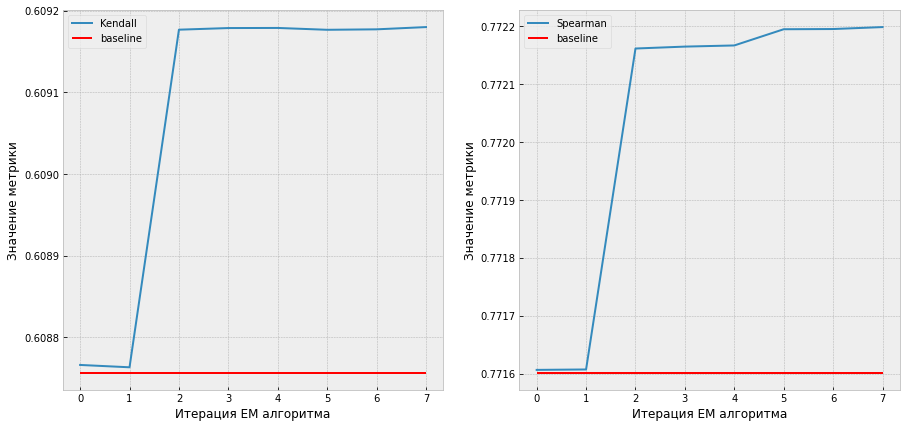

In [57]:
plot_target_metrics(metrics_history)

# 5 "Рейтинг-лист" турниров по сложности вопросов

In [58]:
state_key = "lin_layer.weight"

In [59]:
weights = torch.load(path_to_checkpoint, map_location="cpu")[state_key][0].numpy()

In [60]:
question_complex = pd.DataFrame({"question_complex": weights[len(skils_encoder.categories_[0]):]}, index=questione_complex_encoder.categories_[0])
question_complex.index.name = "answer_id"

In [61]:
question_complex.head()

,question_complex
answer_id,
0,2.016682
1,1.053138
2,-0.548386
3,-0.183907
4,1.979798


## Распредление сложностей вопросов

<AxesSubplot:ylabel='Density'>

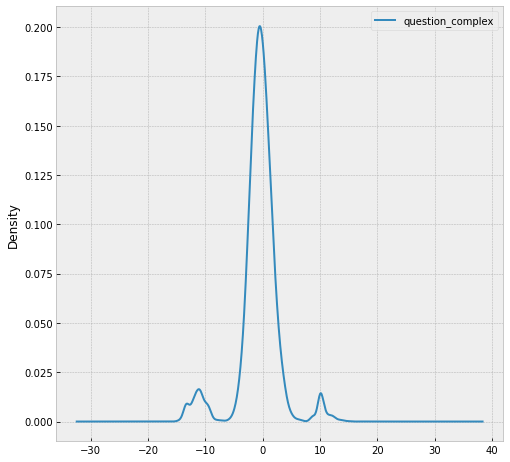

In [62]:
question_complex.plot.kde()

In [63]:
def question_to_complex(questions_ids, question_complexices, top_n: int = 10):
    complexices = question_complexices.loc[questions_ids, "question_complex"].to_numpy()
    return np.mean(complexices)

In [64]:
tours_with_questios = players[["tour_id", "answer_id"]].groupby("tour_id").apply(lambda x: x["answer_id"].to_list())
tours_with_questios = tours_with_questios.apply(lambda x: question_to_complex(x, question_complex, 5))

In [65]:
tours_with_questios.sort_values(ascending=True, inplace=True)

In [66]:
tours_with_questios.head()

tour_id
6149   -13.397834
5717    -4.772788
5930    -4.084815
5427    -3.570785
6101    -3.532730
dtype: float64

In [67]:
target.shape

(17823516,)

In [68]:
top_n = 10

In [69]:
tours.loc[tours_with_questios.iloc[:top_n].index, ["name", "type"]]

,name,type
tour_id,,
6149,Чемпионат Санкт-Петербурга. Первая лига,"{'id': 2, 'name': 'Обычный'}"
5717,Чемпионат Таджикистана,"{'id': 2, 'name': 'Обычный'}"
5930,Зеркало мемориала памяти Михаила Басса,"{'id': 3, 'name': 'Синхрон'}"
5427,День D,"{'id': 3, 'name': 'Синхрон'}"
6101,Воображаемый музей,"{'id': 3, 'name': 'Синхрон'}"
5532,Седьмая октава: Кубок Равноденствия. Лига Наци...,"{'id': 3, 'name': 'Синхрон'}"
5684,Синхрон высшей лиги Москвы,"{'id': 3, 'name': 'Синхрон'}"
5929,Мемориал памяти Михаила Басса,"{'id': 2, 'name': 'Обычный'}"
5928,Угрюмый Ёрш,"{'id': 3, 'name': 'Синхрон'}"


In [70]:
tours.loc[tours_with_questios.iloc[-top_n:].index, ["name", "type"]]

,name,type
tour_id,,
5705,Школьный Синхрон-lite. Выпуск 3.5,"{'id': 8, 'name': 'Асинхрон'}"
5457,Студенческий чемпионат Калининградской области,"{'id': 2, 'name': 'Обычный'}"
5012,Школьный Синхрон-lite. Выпуск 2.5,"{'id': 8, 'name': 'Асинхрон'}"
5827,Шестой киевский марафон. Асинхрон,"{'id': 8, 'name': 'Асинхрон'}"
5013,(а)Синхрон-lite. Лига старта. Эпизод V,"{'id': 8, 'name': 'Асинхрон'}"
6254,Школьная лига,"{'id': 5, 'name': 'Общий зачёт'}"
5955,Школьная лига. III тур.,"{'id': 8, 'name': 'Асинхрон'}"
5936,Школьная лига. I тур.,"{'id': 8, 'name': 'Асинхрон'}"
5438,Синхрон Лиги Разума,"{'id': 3, 'name': 'Синхрон'}"


Интуитивно в список турниров со сложными вопросами попали чемпионаты, а также турниры высшей лиги. В спсиок простых турниров попали более локальнеы туриниы. Некторые и них с упоминанием lite. Соответсвенно, ожидаемо, что чемионаты или турниры высшей лиги будут сложнее чем школьные лиги или студенческие чемпионаты.

Посмотрим на визуализацию ответов команд в этих турнирах.

In [71]:
def plot_tour(team_res, tours, tour_id):
    masks = []
    team_ids = []
    for team_id in team_res[tour_id]:
        if team_res[tour_id][team_id].mask:
            masks.append(team_res[tour_id][team_id].mask)
            team_ids.append(team_id)
    try:
        fig = plt.figure(figsize=(15, 20))
        ax = fig.add_subplot(111)
        ax.imshow(tuple(zip(*masks)), cmap="gray")
        ax.set_xticks([])
        ax.grid(False)
        ax.grid(True, axis="y", linewidth=2, color="red")
        ax.set_ylabel("Номер вопроса")
        ax.set_xlabel("Ответы команды")
        ax.set_title(tours.loc[tour_id, "name"])
    except TypeError:
        pass

## Самые сложные турниры

Виуализация ответов на вопросы. Белый цвет означает, что команда ответила на вопрос. Чёрный что не ответила. 

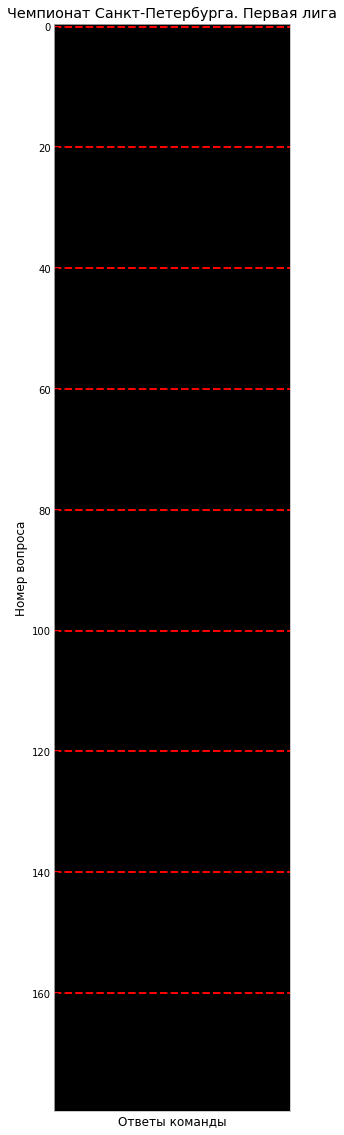

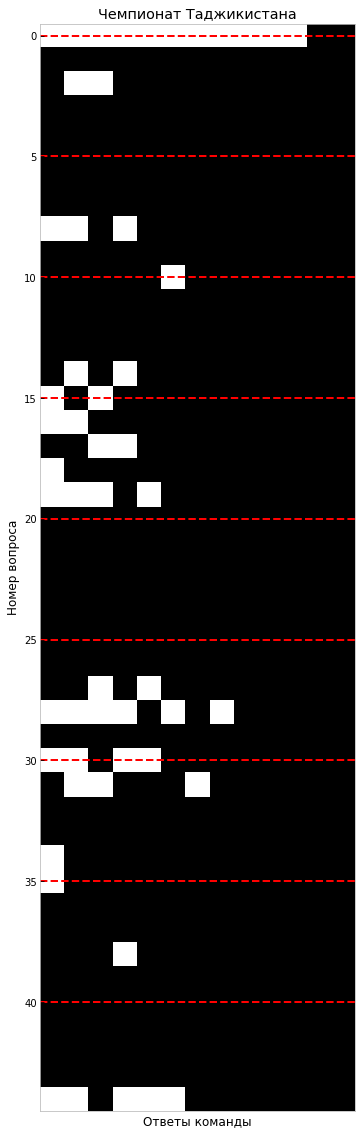

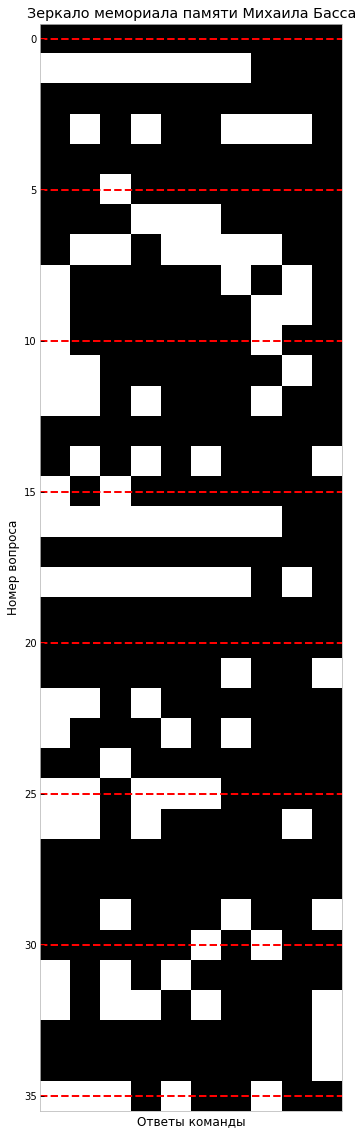

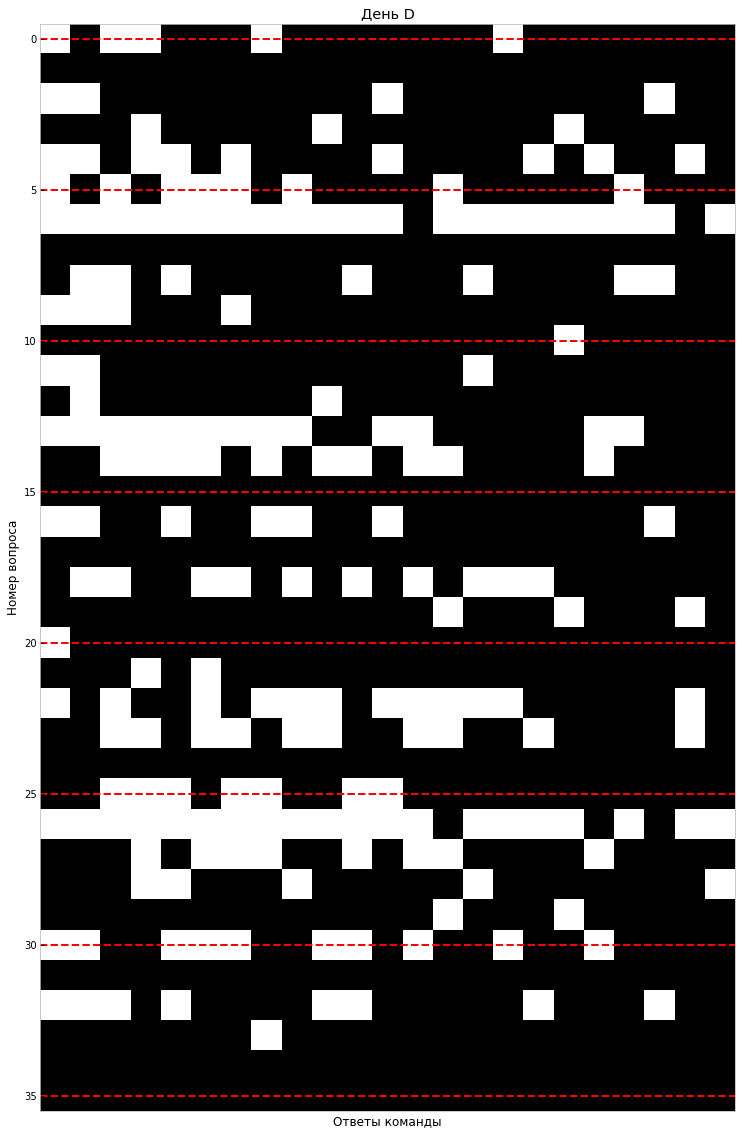

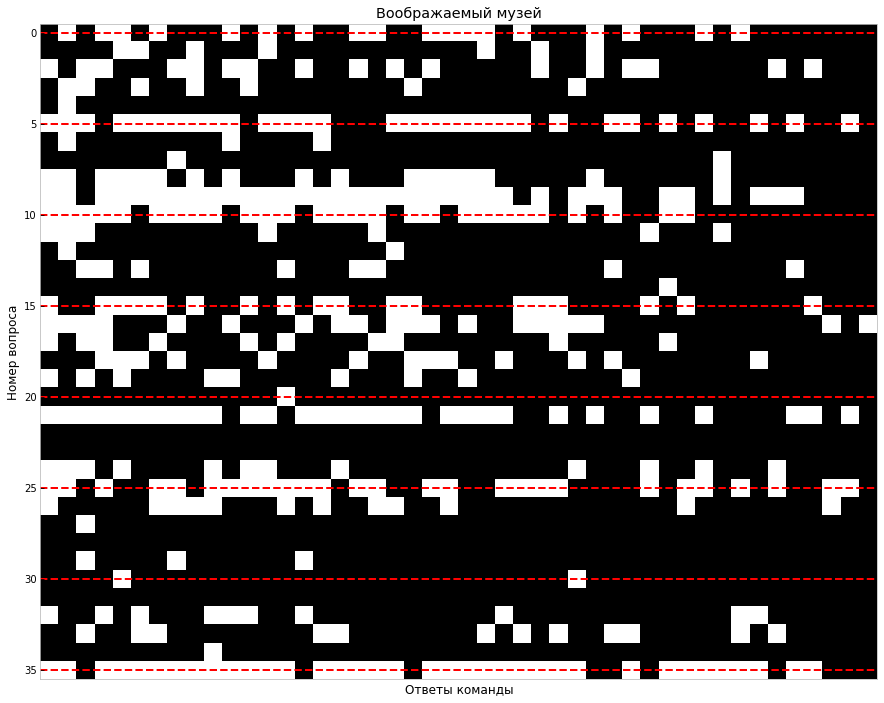

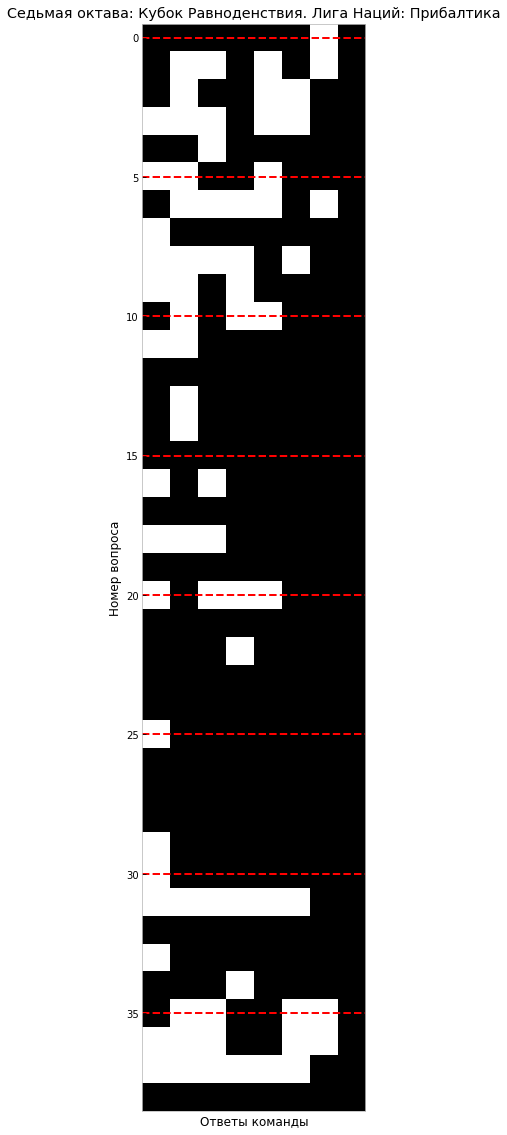

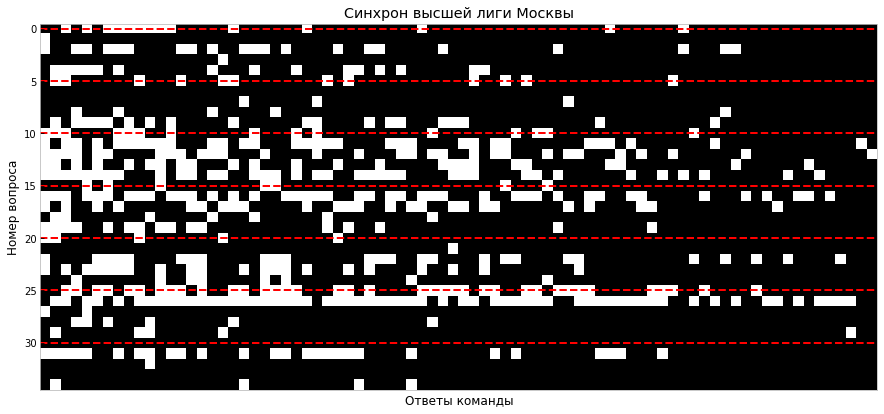

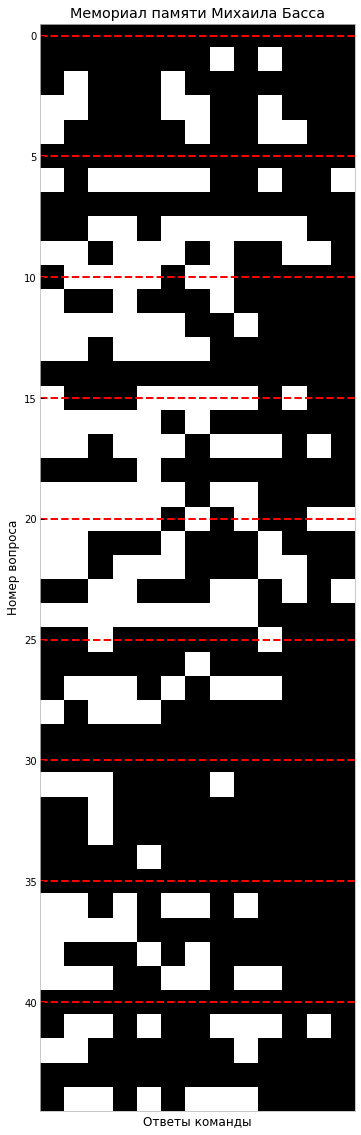

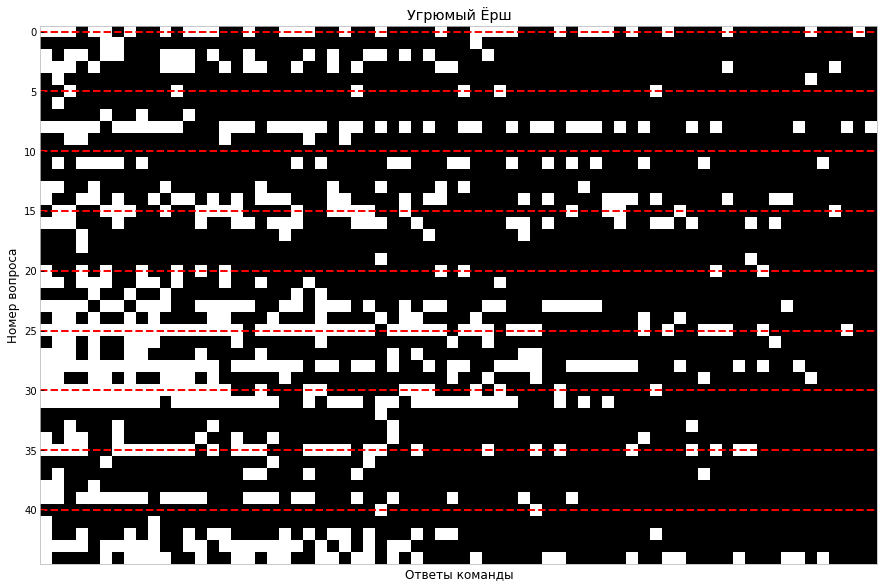

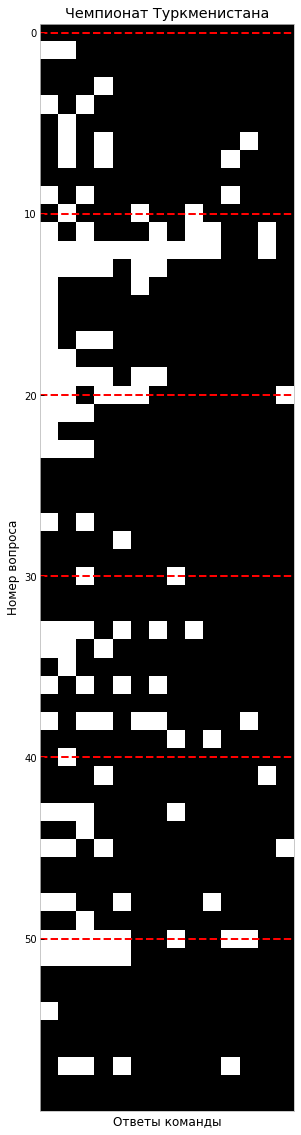

In [72]:
for tour_id in tours_with_questios.iloc[:10].index:
    plot_tour(team_res, tours, tour_id)

## Самые простые турниры

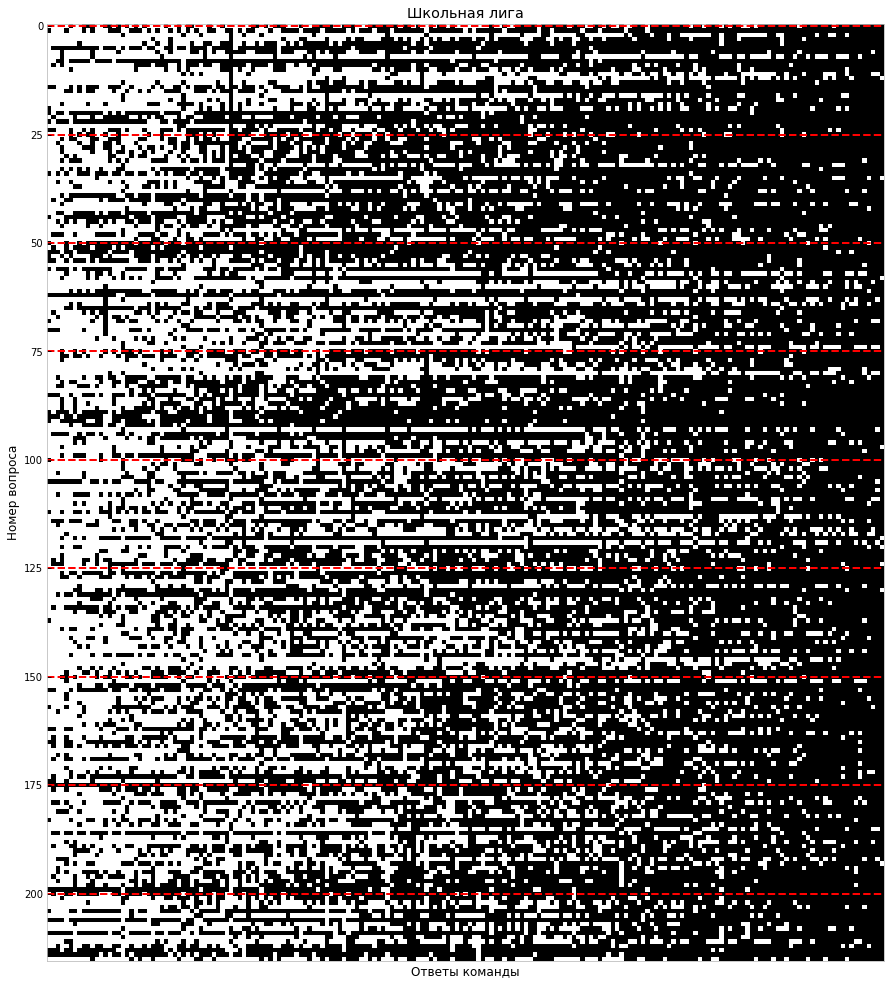

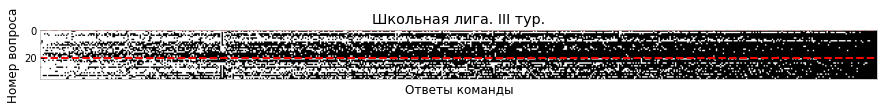

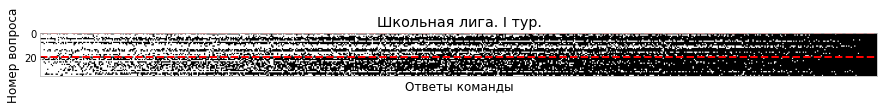

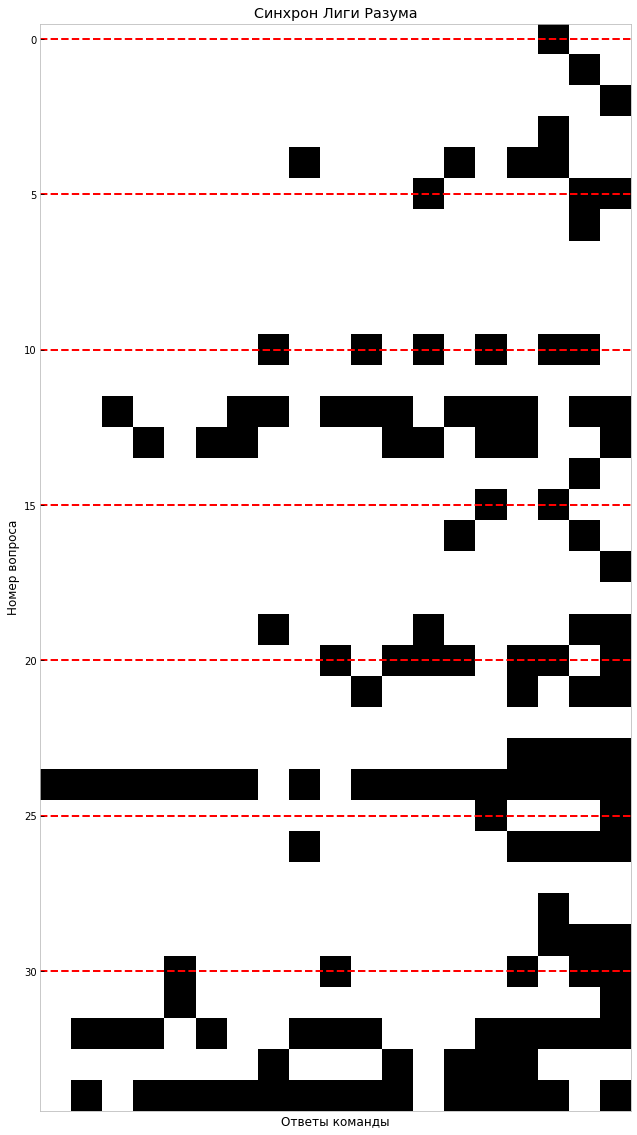

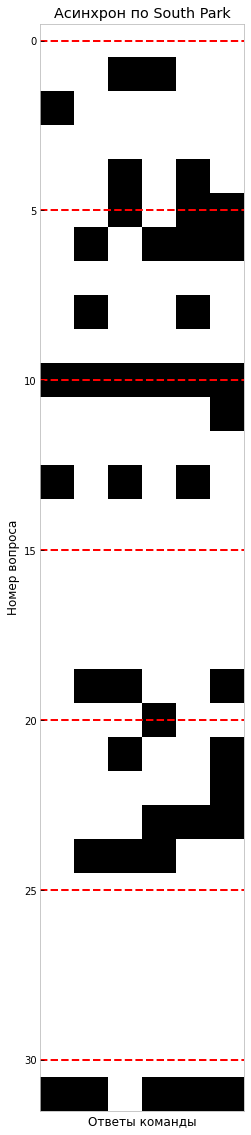

In [73]:
for tour_id in tours_with_questios.iloc[-5:].index:
    plot_tour(team_res, tours, tour_id)

# 6 Бонус топ игроков

In [74]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [75]:
players_total_questions = players.groupby("player_id").agg(total_answers=("answer_id", "count"), total_tours=("tour_id", pd.Series.nunique))

In [76]:
player_ratings = get_player_skills(skils_encoder, weights)

In [77]:
player_skill_quest = players_total_questions.join(player_ratings)
player_skill_quest.sort_values("skill", inplace=True, ascending=False)

In [78]:
top_n = 15

In [79]:
player_skill_quest.head(n=top_n)

,total_answers,total_tours,skill
player_id,,,
27403,2175,55,3.107517
4270,2689,67,2.970896
28751,3770,95,2.918128
27822,3210,79,2.829770
30270,3732,87,2.758515
40411,45,1,2.755654
30152,4845,124,2.745628
38175,36,1,2.685601
20691,1581,37,2.647541


Т. к. нам нужно, чтобы игрок отиграл хотя бы несколько турниров, то возьмём нижнию границу для числа вопросов, равное:

In [80]:
min_answers = player_skill_quest["total_answers"].quantile(0.2)

In [81]:
min_answers

36.0

Т. к. игроки мало играли, то их влияние на командный результат будет незначительным. Скорее всего это игроки, которые попробовали сыграть несколько раз и больше не играли. Данных для оценки их "силы" с точки зрения статистики достаточно мало, поэтому можно убраь их из данных для обучения.

In [82]:
players_with_many_answers = player_skill_quest[player_skill_quest["total_answers"] > min_answers].index

In [83]:
players.shape

(17823516, 5)

In [84]:
filtered_players = players[players["player_id"].isin(players_with_many_answers)]

In [85]:
filtered_players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [86]:
filtered_players.shape

(17185131, 5)

In [87]:
skils_encoder, questione_complex_encoder, features, target = get_features_target(filtered_players, feature_dtype)

In [88]:
regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=50, fit_intercept=True)
regression.fit(features, target)

[LibLinear]

LogisticRegression(C=1000, max_iter=50, penalty='l1', solver='liblinear',
                   verbose=2)

In [89]:
metrics_history, path_to_checkpoint = train_em(features, target, filtered_players, skils_encoder, test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-10 00:58:07,776 INFO em_algo __init__ Will train logistic regression on cuda
2021-04-10 00:58:17,551 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-10 00:58:17,569 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.60it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:00,538 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:00,542 INFO em_algo _validate Kendall +0.000863
2021-04-10 00:59:00,543 INFO em_algo _validate Spearman -0.000202
2021-04-10 00:59:00,544 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:59:00,559 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6096194992807542, 'Spearman': 0.7713992385541419}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.61it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:12,457 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:12,459 INFO em_algo _validate Kendall +0.001278
2021-04-10 00:59:12,460 INFO em_algo _validate Spearman +0.000354
2021-04-10 00:59:12,462 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:59:12,472 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:59:12,474 INFO em_algo _validate Kendall +0.000415
2021-04-10 00:59:12,476 INFO em_algo _validate Spearman +0.000556
2021-04-10 00:59:12,480 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100345883026457, 'Spearman': 0.7719551711933459}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.61it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:24,104 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:24,106 INFO em_algo _validate Kendall +0.001281
2021-04-10 00:59:24,108 INFO em_algo _validate Spearman +0.000357
2021-04-10 00:59:24,112 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:59:24,119 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:59:24,121 INFO em_algo _validate Kendall +0.000003
2021-04-10 00:59:24,124 INFO em_algo _validate Spearman +0.000003
2021-04-10 00:59:24,126 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100372407487502, 'Spearman': 0.7719579678109547}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.62it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:35,898 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:35,899 INFO em_algo _validate Kendall +0.001282
2021-04-10 00:59:35,901 INFO em_algo _validate Spearman +0.000357
2021-04-10 00:59:35,904 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-10 00:59:35,910 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:59:35,912 INFO em_algo _validate Kendall +0.000001
2021-04-10 00:59:35,913 INFO em_algo _validate Spearman +0.000001
2021-04-10 00:59:35,915 INFO em_algo _validate Corr coefficients: {'Kendall': 0.610038337532986, 'Spearman': 0.771958641589421}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.60it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:47,143 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:47,145 INFO em_algo _validate Kendall +0.001251
2021-04-10 00:59:47,146 INFO em_algo _validate Spearman +0.000348
2021-04-10 00:59:47,146 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:59:47,149 INFO em_algo _validate Kendall -0.000031
2021-04-10 00:59:47,155 INFO em_algo _validate Spearman -0.000010
2021-04-10 00:59:47,157 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100071728287868, 'Spearman': 0.7719490728530999}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.58it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 00:59:58,682 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 00:59:58,683 INFO em_algo _validate Kendall +0.001249
2021-04-10 00:59:58,685 INFO em_algo _validate Spearman +0.000347
2021-04-10 00:59:58,688 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 00:59:58,690 INFO em_algo _validate Kendall -0.000002
2021-04-10 00:59:58,691 INFO em_algo _validate Spearman -0.000000
2021-04-10 00:59:58,693 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100053393135348, 'Spearman': 0.7719488707501575}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.60it/s, Binary cross entropy=0.466, MAE=0.000213]


2021-04-10 01:00:10,149 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 01:00:10,150 INFO em_algo _validate Kendall +0.001272
2021-04-10 01:00:10,151 INFO em_algo _validate Spearman +0.000355
2021-04-10 01:00:10,152 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 01:00:10,153 INFO em_algo _validate Kendall +0.000023
2021-04-10 01:00:10,158 INFO em_algo _validate Spearman +0.000007
2021-04-10 01:00:10,161 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100285670131826, 'Spearman': 0.7719561979703142}


Train logistic regression: 100%|███████████████| 5/5 [00:03<00:00,  1.60it/s, Binary cross entropy=0.466, MAE=0.000212]


2021-04-10 01:00:21,678 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-10 01:00:21,679 INFO em_algo _validate Kendall +0.001270
2021-04-10 01:00:21,681 INFO em_algo _validate Spearman +0.000354
2021-04-10 01:00:21,684 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-10 01:00:21,686 INFO em_algo _validate Kendall -0.000002
2021-04-10 01:00:21,687 INFO em_algo _validate Spearman -0.000001
2021-04-10 01:00:21,691 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6100265959339444, 'Spearman': 0.771955519038137}


M step: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [01:33<00:00, 11.64s/it]


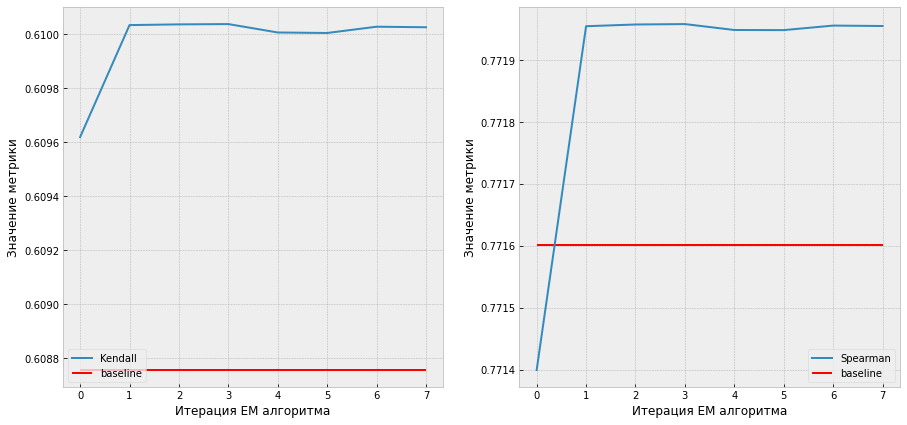

In [90]:
plot_target_metrics(metrics_history)

Результаты по сранению с EM алгоритмом при обучении нв всех игроках не сильно изменились. Один из коэффициентов вырос, а другой стал немного хуже.

In [91]:
weights = torch.load(path_to_checkpoint, map_location="cpu")[state_key][0].numpy()

In [92]:
player_ratings = get_player_skills(skils_encoder, weights)
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [93]:
player_ratings = player_ratings.join(real_data)

Топ игроков по сравнению с реальным рейтингом 2019 года.

In [94]:
player_ratings.iloc[:15]

,skill,Место
27403,3.036342,5.0
4270,2.899510,6.0
28751,2.846513,2.0
27822,2.758185,3.0
30270,2.686891,4.0
40411,2.684561,NaN
30152,2.673887,1.0
20691,2.575957,NaN
18036,2.518183,NaN
22799,2.495644,NaN


Распредление рейтинга игроков не сильно изменилось по сранению с реальным, поэтому отсекать по количеству вопросов не даёт качественного скачка, но всё равно это полезно т. к. даёт возможность отфильтровать игроков со слишком малым количеством ответов. 

Text(0.5, 1.0, 'Распредление "силы игроков"')

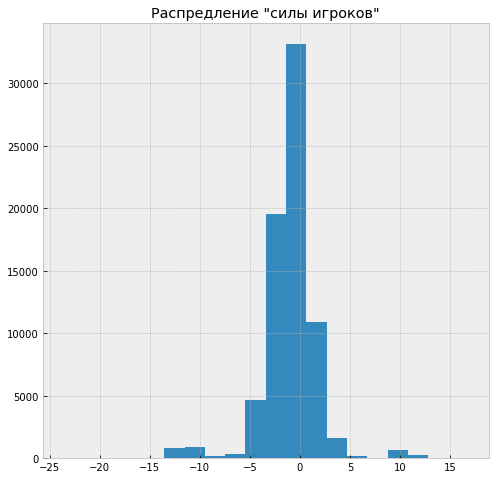

In [95]:
plt.hist(regression.coef_[0], bins=20)
plt.title("Распредление \"силы игроков\"")

# 7 Бонус обучение на всех турнирах

Вычислительных ресурсов обучить на всех турнирах не хватило, поэтому пришлось взять подмножество турниров с 2018 года.

In [96]:
train_data = list(pathlib.Path(
    "data", "team_res").glob("train_team*.pickle"))

In [97]:
train_data

[WindowsPath('data/team_res/train_team_results.pickle'),
 WindowsPath('data/team_res/train_team_results_2018.pickle')]

In [98]:
train_team_res = None
for data_path in train_data:
    train_players = load_pickle(data_path).to_player_dataframe(filter_by_mask=True)
    if train_players is None:
        continue
    print(train_players.shape)
    if train_team_res is None:
        train_team_res = train_players
    else:
        train_team_res = train_team_res.append(train_players)

Convert to dataframe: 100%|██████████████████████████████████████████████████████████| 682/682 [01:23<00:00,  8.17it/s]


(17823516, 5)


Convert to dataframe: 100%|██████████████████████████████████████████████████████████| 618/618 [01:06<00:00,  9.25it/s]


(15501696, 5)


In [99]:
train_team_res.shape

(33325212, 5)

In [100]:
skils_encoder, questione_complex_encoder, features, target = get_features_target(train_team_res, feature_dtype)

In [101]:
regression = linear_model.LogisticRegression(
    penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=25, fit_intercept=True)
regression.fit(features, target)

[LibLinear]

LogisticRegression(C=1000, max_iter=25, penalty='l1', solver='liblinear',
                   verbose=2)

In [102]:
player_ratings = get_player_skills(skils_encoder, regression.coef_[0])
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [103]:
estimate_rank(test_team_ratings, player_ratings)

{'Kendall': 0.584186795994384, 'Spearman': 0.7478868958828834}

После обучения на данных с 2018 года. Результатыт немного ухудшились. Видимо, рейтинг игроков в большей мере зависит от результатов последних игр, что логично. Игрок мог играть хорошо раньше, но позже стал меньше времни уделять подготовке и его результаты стали хуже. Также могут быть игроки, которые на самом деле не сильно вносят вклад в командный результат. Т. е. фактически может быь какой-то топ-игрококв, которые вносят существенный вклад в результат команды.

Их рейтинги должны быть очень высокими.

Было бы интересно рассмотреть рейтинговую систему на графах. Вершины это сами игроки. Их рейтинги это арибуты вершин. Турниры пресдтавляют собой локальнеы объединения игроков. Получается динамический процесс на графах. Задача в момент времени $t$ предсказать результат ответа на вопрос команды как некоторая агрегация ответов игроков. Ответ игрока зависит от некоторых признаков в вершине. Например, вероятность ответа также моделируется логистической регрессией, но благодаря агрегации признаков от сосоедних вершин (участников в момент времени $t$) можно было бы получать ответ команды.

Потеницально с помощью введения динамики и применения нейронных сетей на графах можно было бы динамиччекси расчитывать рейтинги игроков в нужный момент времени и обновлять его при поступлении новых данных.